# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12728\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,5560.67,1.00,-131.89,3375.74,3243.85
OMUSDT,526.32,3795.38,0.68,0.00,3269.06,3269.06
BTCUSDT,601.02,854.84,0.15,3.54,253.82,257.36
SOLUSDT,281.20,308.56,0.06,0.00,27.36,27.36
JASMYUSDT,387.46,273.38,0.05,0.00,-114.07,-114.07
ETHUSDT,250.75,191.75,0.03,0.00,-58.99,-58.99
TRXUSDT,76.87,115.23,0.02,-10.72,38.36,27.64
BBUSDT,60.18,20.37,0.00,-39.73,-39.80,-79.53
BNBUSDT,1.14,1.14,0.00,-10.61,-0.00,-10.61
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

449

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [28]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-02-17    2825.976428
2025-02-18    2961.835850
2025-02-19    2983.020523
2025-02-20    3217.723265
2025-02-21    3080.105239
Name: Total, Length: 152, dtype: float64

In [39]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-02-17   -107.557051
2025-02-18    135.859423
2025-02-19     21.184673
2025-02-20    234.702742
2025-02-21   -137.618026
Name: Total, Length: 152, dtype: float64

In [40]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [41]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [42]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [43]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_12728\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [44]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [45]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [46]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

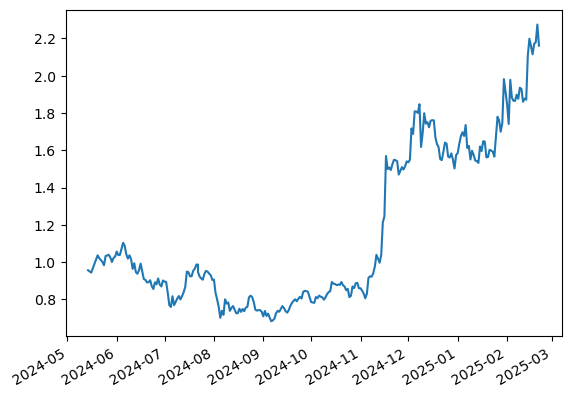

In [47]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

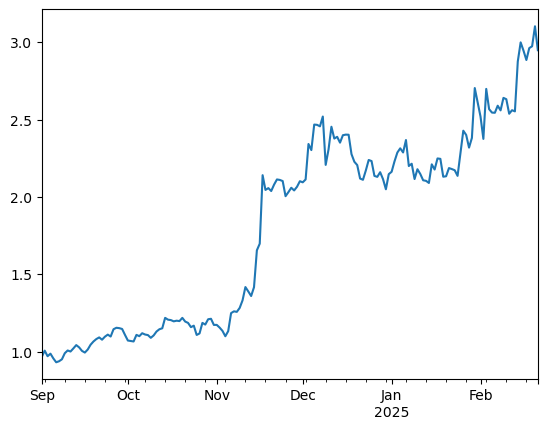

In [48]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [50]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [53]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [54]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [57]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.5002
BNBUSDT,0.2719
XRPUSDT,0.1331
SUIUSDT,0.0487
PEPEUSDT,0.0251
DEXEUSDT,0.0138
AAVEUSDT,0.0072
ARBUSDT,0.0000
INJUSDT,0.0000
IMXUSDT,0.0000


In [58]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

In [59]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

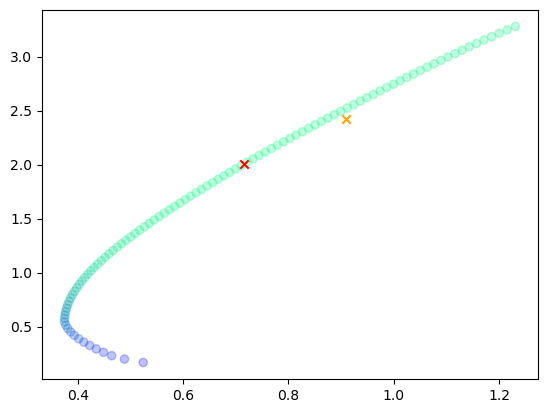

In [60]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [61]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [62]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3795.381687,0.682540,0.2495,0.433040
BTCUSDT,854.843647,0.153730,0.0000,0.153730
SOLUSDT,308.564964,0.055491,0.0000,0.055491
JASMYUSDT,273.384312,0.049164,0.0000,0.049164
ETHUSDT,191.754529,0.034484,0.0000,0.034484
TRXUSDT,115.231194,0.020723,0.0000,0.020723
BBUSDT,20.372134,0.003664,0.0000,0.003664
BNBUSDT,1.137829,0.000205,0.1382,-0.137995
PEPEUSDT,0.000002,0.000000,0.0255,-0.025500
XRPUSDT,0.000000,0.000000,0.1356,-0.135600


### Current results

In [64]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [65]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']

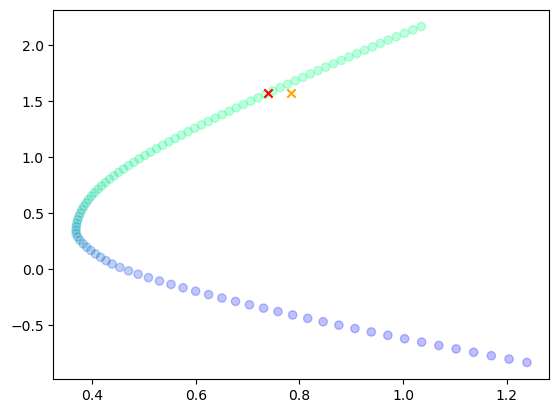

In [66]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [67]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3795.381687,0.682540,0.656184,0.026356
BTCUSDT,854.843647,0.153730,0.237282,-0.083552
SOLUSDT,308.564964,0.055491,0.000000,0.055491
JASMYUSDT,273.384312,0.049164,0.000000,0.049164
ETHUSDT,191.754529,0.034484,0.000000,0.034484
TRXUSDT,115.231194,0.020723,0.106534,-0.085811
BBUSDT,20.372134,0.003664,0.000000,0.003664
BNBUSDT,1.137829,0.000205,0.000000,0.000205
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [69]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [70]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

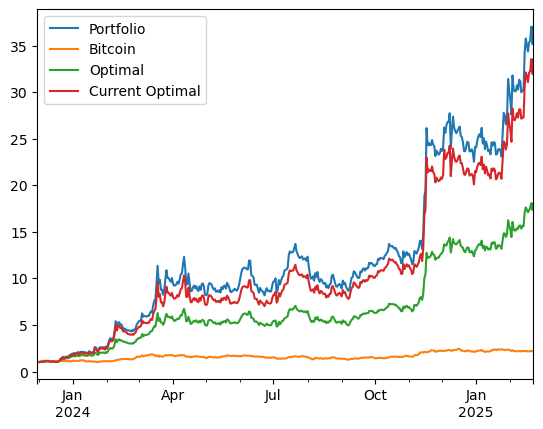

In [71]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [72]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

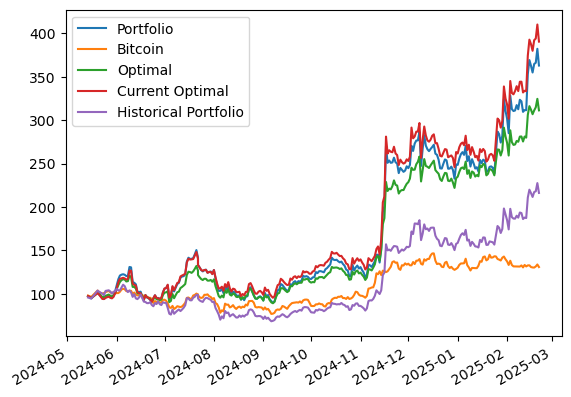

In [73]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [74]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-02-12,311.536207,133.119928,281.071373,333.777397,187.689310
2025-02-13,311.424842,131.392435,279.825733,333.300190,187.139545
2025-02-14,353.083296,132.600497,306.035964,374.294479,210.740797
2025-02-15,369.162059,132.694548,316.071716,392.687590,219.830088
2025-02-16,362.560257,130.705625,311.962898,387.475800,215.906817
2025-02-17,354.832913,130.245024,306.779435,379.835295,211.469567
2025-02-18,364.678204,130.097725,311.178776,392.061716,217.110239
2025-02-19,366.054977,131.413663,314.730965,393.987443,217.982078
2025-02-20,382.138566,133.652549,324.480163,410.106615,227.454796
2025-02-21,362.865665,130.734531,311.231443,390.432398,216.124900


## Volatilities

In [76]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.669433
 dtype: float64,
 0.6701560043681654)

In [77]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.783336
 dtype: float64,
 0.7833360722764882)

In [78]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.909169
Bitcoin            0.420752
Optimal            0.670156
Current Optimal    0.859866
dtype: float64

In [79]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4754443484974967

In [80]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

3.4650449153711778

In [81]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

2.0038147772165686

## Risk Contribution

In [83]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.183737,0.129998,0.006771,0.038776,0.008351,0.030425
BTCUSDT,0.356161,0.300000,0.014161,0.105846,0.035477,0.070369
DEXEUSDT,0.004677,0.002792,0.000161,0.001368,0.000015,0.001354
OMUSDT,44.600542,0.461990,0.972540,0.808286,0.720023,0.088262
SUIUSDT,0.045648,0.027952,0.001588,0.014005,0.001562,0.012443
XRPUSDT,0.144132,0.077268,0.004778,0.031719,0.006012,0.025707


In [84]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.685110,0.656184,0.900105,0.904623,0.843760,0.060863
BTCUSDT,0.096515,0.237282,0.069208,0.057203,0.016010,0.041193
TRXUSDT,0.041473,0.106534,0.030687,0.038174,0.013445,0.024729


In [85]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.857434,0.686869,0.928168,0.893045,0.823866,0.069179
BTCUSDT,0.061629,0.151515,0.043534,0.036231,0.005817,0.030413
SOLUSDT,-0.005075,0.060606,0.011342,0.026453,0.002601,0.023852
JASMYUSDT,-0.019704,0.050505,0.006291,0.030616,0.004945,0.025671
ETHUSDT,-0.006156,0.030303,0.004932,0.008238,0.000435,0.007802
TRXUSDT,0.007865,0.020202,0.005733,0.005417,0.000431,0.004986


# Value At Risk

## Historical

### Optimal Weights

In [89]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05010007818287486, -0.0757430450410973)

### Current Weights

In [91]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05174704117895537, -0.07877154391826904)

In [92]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [93]:
var=historical_var.iloc[row]
var

OMUSDT      -0.037080
BTCUSDT     -0.003370
SOLUSDT     -0.004357
JASMYUSDT   -0.005575
ETHUSDT     -0.001160
TRXUSDT     -0.000247
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.051788
Name: 2024-10-25 00:00:00, dtype: float64

In [94]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.065736
BTCUSDT     -0.003763
SOLUSDT     -0.003261
JASMYUSDT   -0.004120
ETHUSDT     -0.001279
TRXUSDT     -0.000614
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.078772
dtype: float64

## Parametric

### Optimal Weights

In [97]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06943891071686674, -0.08900148474350192)

### Current Weights

In [99]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08116618105271137, -0.10403260290338215)

## Multivariate

### Optimal Weights

In [102]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060403580079410275, -0.07825231971890649)

### Current Weights

In [104]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07524255482407088, -0.09521257761174987)

In [105]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.066433
BTCUSDT     -0.002693
SOLUSDT     -0.002215
JASMYUSDT   -0.002328
ETHUSDT     -0.000711
TRXUSDT     -0.000666
Portfolio   -0.075045
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [109]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0628362553476604, -0.08158324456303392)

### Current Weights

In [111]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07625283486895261, -0.0967963038820549)

In [112]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.066977
BTCUSDT     -0.002368
SOLUSDT     -0.001989
JASMYUSDT   -0.002486
ETHUSDT     -0.000684
TRXUSDT     -0.000459
Portfolio   -0.074963
dtype: float64

## Student Copula

### Optimal Weights

In [115]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06158360215039107, -0.0790998896742155)

### Current Weights

In [117]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07658288045776598, -0.09825952887324357)

In [118]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.069125
BTCUSDT     -0.002604
SOLUSDT     -0.001997
JASMYUSDT   -0.002087
ETHUSDT     -0.000681
TRXUSDT     -0.000126
Portfolio   -0.076620
dtype: float64

## Gumbel Copula

### Optimal Weights

In [121]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12508277064910556, -0.18284437448894572)

### Current Weights

In [123]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15748840824685775, -0.22654371478685636)

In [124]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.158992
BTCUSDT      0.000988
SOLUSDT      0.000130
JASMYUSDT   -0.000101
ETHUSDT      0.000155
TRXUSDT      0.000089
Portfolio   -0.157731
dtype: float64

## Monte Carlo

### Optimal

In [127]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [128]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07020138146061787, -0.08809205878502917)

### Current Weights

In [130]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08365924694678654, -0.10371359259095624)

In [131]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.074772
BTCUSDT     -0.003009
SOLUSDT     -0.001927
JASMYUSDT   -0.002183
ETHUSDT     -0.000668
TRXUSDT     -0.000385
Portfolio   -0.082944
dtype: float64

## VaR Violation

In [133]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057601,-0.103739,-0.087588,-0.019538
2024-01-15,-0.057601,-0.103714,-0.087854,0.021066
2024-01-16,-0.057601,-0.103837,-0.082310,0.052407
2024-01-17,-0.057601,-0.106215,-0.089844,-0.033994
2024-01-18,-0.057601,-0.108147,-0.087943,-0.029930
...,...,...,...,...
2025-02-18,-0.051589,-0.094872,-0.086516,0.014340
2025-02-19,-0.051589,-0.094868,-0.084184,0.011415
2025-02-20,-0.051589,-0.095123,-0.082603,0.030976
2025-02-21,-0.051589,-0.097445,-0.086974,-0.040831


In [134]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.044777,-0.084428,-0.083811,-0.015239
2024-05-29,-0.044777,-0.082267,-0.077475,-0.007163
2024-05-30,-0.044777,-0.072471,-0.074204,0.027373
2024-05-31,-0.044777,-0.076632,-0.075295,0.049685
2024-06-01,-0.044777,-0.083409,-0.074922,0.067018
...,...,...,...,...
2025-02-18,-0.046101,-0.100680,-0.091639,0.027746
2025-02-19,-0.035381,-0.094292,-0.083110,0.003775
2025-02-20,-0.035381,-0.095426,-0.080025,0.043938
2025-02-21,-0.048647,-0.103020,-0.092373,-0.050434


<Axes: >

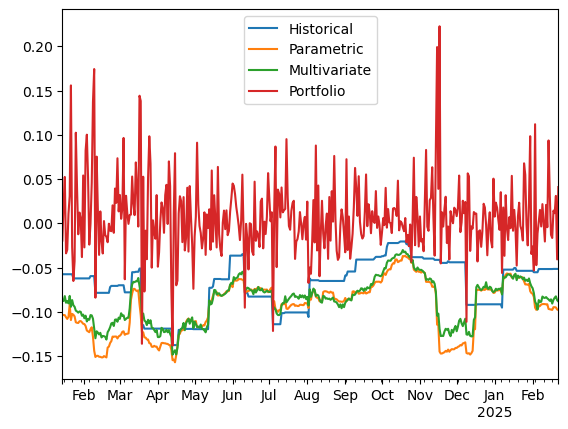

In [135]:
var_data.plot()

<Axes: >

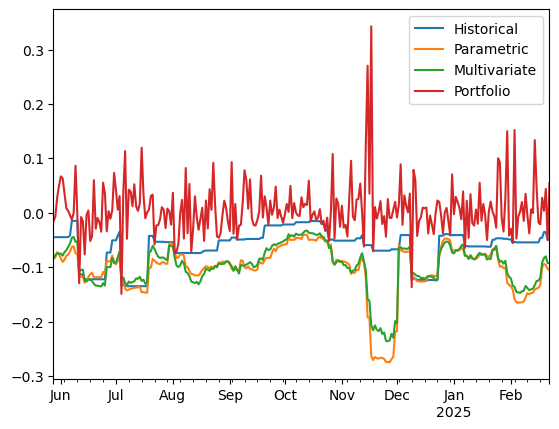

In [136]:
current_var_data.plot()

In [137]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024631,0.007389,0.007389
Kupiec Stat,6.711926,23.892566,23.892566
P-value,0.009577,0.000001,0.000001


In [138]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.059041,0.01107,0.01107
Kupiec Stat,0.441859,12.479894,12.479894
P-value,0.506227,0.000411,0.000411


# Principal Component Analysis

## Historical PCA

In [141]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78493198, 0.06735769, 0.05831852, 0.04955534, 0.03983646])

In [142]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.016196
ADAUSDT     0.016094
ALGOUSDT    0.018563
APTUSDT     0.016790
ARBUSDT     0.018023
              ...   
WBTCUSDT    0.009131
WLDUSDT     0.022647
XLMUSDT     0.013428
XRPUSDT     0.011560
XTZUSDT     0.016657
Name: PC1, Length: 61, dtype: float64

<Axes: >

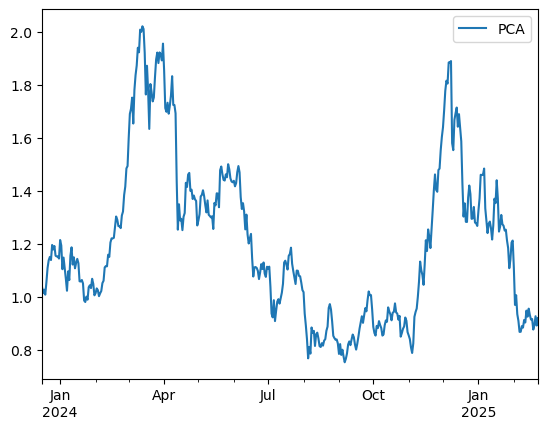

In [143]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

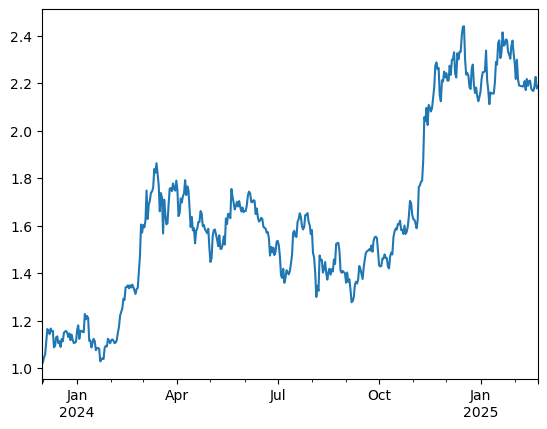

In [144]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [145]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.430227
WBETHUSDT    0.447544
ETHUSDT      0.447877
ATOMUSDT     0.469603
DOTUSDT      0.471409
ETCUSDT      0.476791
NEXOUSDT     0.486852
ADAUSDT      0.525973
AVAXUSDT     0.531918
WBTCUSDT     0.532477
EOSUSDT      0.532516
BTCUSDT      0.533021
IOTAUSDT     0.561146
FILUSDT      0.564662
ARBUSDT      0.575229
GRTUSDT      0.582512
XTZUSDT      0.589799
LINKUSDT     0.600473
SOLUSDT      0.611813
dtype: float64

<Axes: >

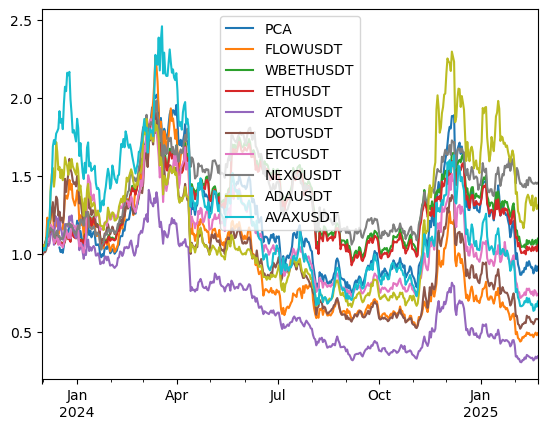

In [146]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

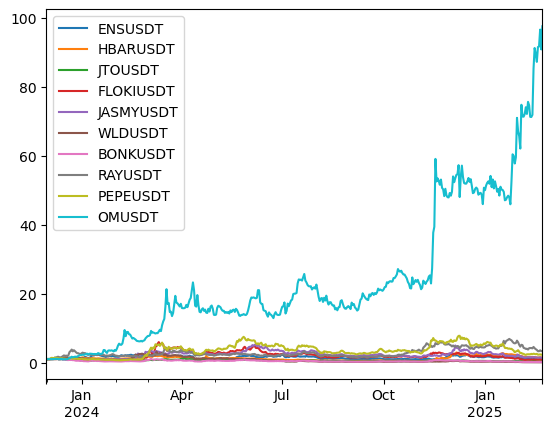

In [147]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [149]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.56930971, 0.14983876, 0.11729419, 0.09383614, 0.0697212 ])

In [150]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.096334
BTCUSDT      0.058673
SOLUSDT      0.097749
JASMYUSDT    0.174837
ETHUSDT      0.084601
TRXUSDT      0.054745
BBUSDT       0.207022
BNBUSDT      0.065765
PEPEUSDT     0.160274
Name: PC1, dtype: float64

<Axes: >

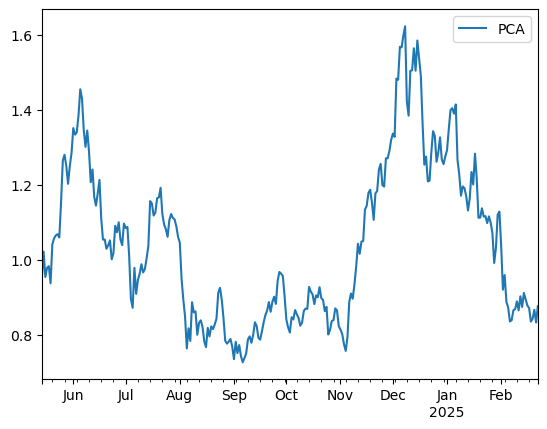

In [151]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

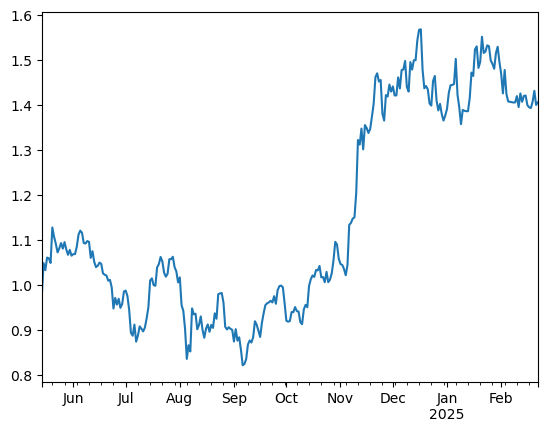

In [152]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.440888
BNBUSDT      0.482907
BTCUSDT      0.499695
SOLUSDT      0.500930
JASMYUSDT    0.696112
PEPEUSDT     0.750306
BBUSDT       0.787467
TRXUSDT      0.914607
OMUSDT       0.999450
dtype: float64

<Axes: >

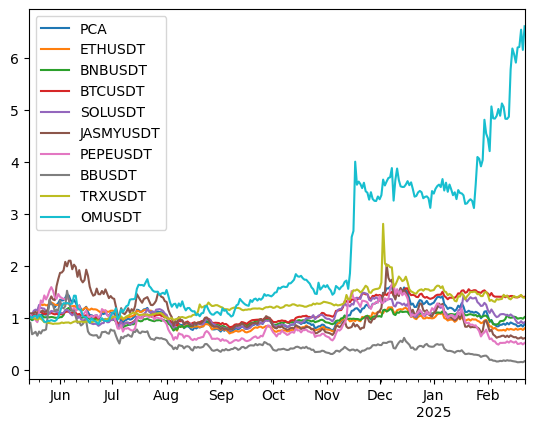

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [156]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.908714
BBUSDT       1.568661
JASMYUSDT    1.350437
SOLUSDT      1.167963
BTCUSDT      1.000000
ETHUSDT      0.974906
OMUSDT       0.903547
BNBUSDT      0.668502
TRXUSDT      0.333403
Name: BTCUSDT, dtype: float64

In [157]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.654699
BBUSDT       2.597782
OMUSDT       2.415973
PEPEUSDT     2.124058
SOLUSDT      1.563675
ETHUSDT      1.185857
BNBUSDT      1.027984
TRXUSDT      1.009684
BTCUSDT      1.000000
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [159]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [160]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.294460
ETHUSDT,0.204363
BBUSDT,0.174029
PEPEUSDT,0.157668
SOLUSDT,0.141566
TRXUSDT,0.108869
JASMYUSDT,0.094729
BNBUSDT,0.035231
OMUSDT,0.012506


### Regression to PCA

In [162]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.48183641652453

In [163]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.317104
BNBUSDT      1.136715
ETHUSDT      1.029083
PCA          1.000000
SOLUSDT      0.756002
JASMYUSDT    0.444018
PEPEUSDT     0.424313
BBUSDT       0.387866
TRXUSDT      0.257304
OMUSDT       0.240344
dtype: float64

In [164]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.975461
ETHUSDT      1.249039
TRXUSDT      1.000377
PCA          1.000000
BNBUSDT      0.947176
SOLUSDT      0.923155
PEPEUSDT     0.611214
BBUSDT       0.568670
JASMYUSDT    0.528728
OMUSDT       0.258225
dtype: float64

### Correlation Matrix

<Axes: >

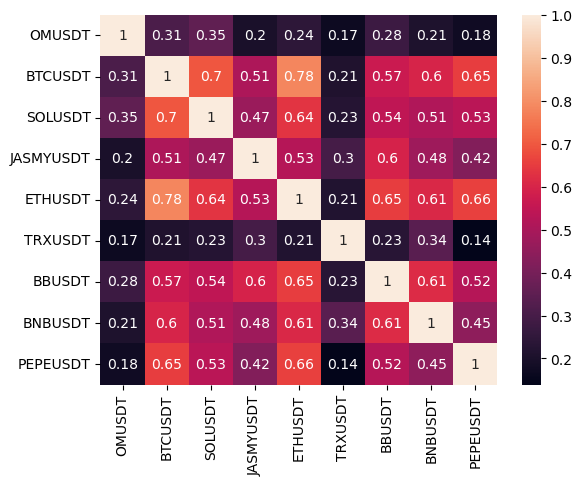

In [166]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

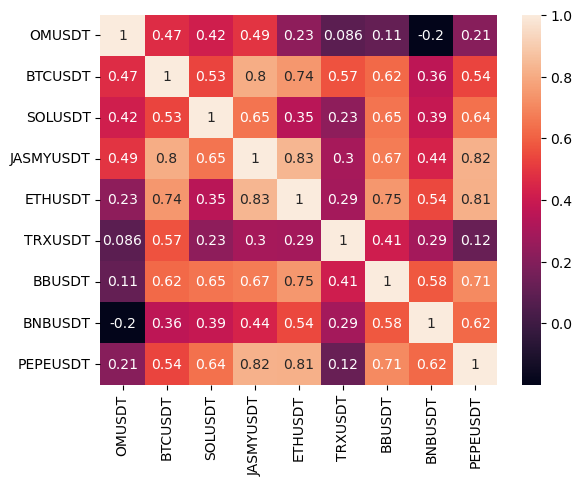

In [167]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [169]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [170]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-07-17,0.007546,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.767672,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-08-16,1.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-09-15,0.007546,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.362123,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-10-15,0.007546,0.0,0.00000,0.045456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.350729,0.0,0.0,0.0,0.0,0.0,0.000407,0.000000,0.000000,0.0
2024-11-14,0.007546,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.381665,0.0
2024-12-14,0.462798,0.0,0.06919,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.016825,0.162166,0.0
2025-01-13,0.007546,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.024804,0.0
2025-02-12,0.007546,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2025-02-22,0.007546,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.078138,0.0


In [171]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

MKRUSDT     0.520854
OMUSDT      0.277675
LTCUSDT     0.115788
XRPUSDT     0.078138
AAVEUSDT    0.007546
SHIBUSDT    0.000000
Name: 2025-02-22 00:00:00, dtype: float64